# Steam Sentiment Analysis Projekt - Training des DistilBERT Modells

## Einführung

In diesem Abschnitt konzentrieren wir uns auf das **Training eines DistilBERT-Modells**, um Steam Reviews zu klassifizieren. Unser Ziel ist es, eine binäre Klassifizierung durchzuführen, bei der wir vorhersagen, ob ein Spiel auf Basis der Nutzerrezension empfohlen wird oder nicht.

### Iteratives Vorgehen beim Training

Das Training des DistilBERT-Modells erfolgt in mehreren Iterationen, wobei wir unterschiedliche Datenkonfigurationen verwenden. Wir starten mit einer kleinen Datenmenge von **1.000 Beobachtungen** und steigern die Anzahl auf **10.000 Beobachtungen**, um zu sehen, wie sich die Ergebnisse skalieren. Wir analysieren die Performance des Modells unter verschiedenen Bedingungen und Informationen, die wir den Reviews hinzufügen.

---

## Geplante Experimente

Für jedes Experiment wird das DistilBERT-Modell mit unterschiedlichen Zusatzinformationen trainiert, die in den Text der Rezensionen integriert werden:

1. **Nur Reviews**: Zunächst wird das Modell lediglich mit den Rohdaten der Reviews trainiert, um eine Basisleistung zu messen.
2. **Reviews + Genre + Publisher + Spielname**: Im zweiten Schritt erweitern wir die Reviews um das Genre des Spiels und den Publisher. Diese Informationen könnten eine signifikante Auswirkung auf das Modell haben, da gewisse Publisher oder Genres möglicherweise einen Einfluss auf die Bewertungen haben.
3. **Reviews + Emotionen**: Im dritten Experiment integrieren wir die von **GoEmotions** erkannten Emotionen als zusätzliche Merkmale. Emotionen wie „Frustration“, „Freude“ oder „Überraschung“ könnten helfen, die Intention hinter den Bewertungen besser zu erkennen.
4. **Reviews + Genre + Publisher + Emotionen**: Schließlich kombinieren wir alle Informationen – das Genre, den Publisher und die Emotionen – um zu sehen, ob dies zu einer signifikanten Leistungssteigerung führt.

---

## Datenvorbereitung

Die Datenvorbereitung orientiert sich an den folgenden Schritten:

- **Datenanreicherung**: Zusätzliche Informationen wie das Genre, der Publisher und die Emotionen werden am Anfang jeder Review hinzugefügt. Dies könnte beispielsweise folgendermaßen aussehen:

  _"Genre: Action; Publisher: Valve; Emotion: Freude; Review: Dieses Spiel ist einfach fantastisch, ich liebe es!"_

---

## Modellarchitektur und Trainingsprozess

### DistilBERT-Modell

Wir verwenden das **DistilBERT-Modell** für die Textklassifikation, da es im Vergleich zu BERT eine schnellere Verarbeitung bei ähnlicher Genauigkeit ermöglicht. Hier einige Details zum Training:

- **Tokenisierung**: Die Rezensionen werden mit dem DistilBERT-Tokenizer in Tokens umgewandelt, wobei die maximale Textlänge auf 512 Tokens beschränkt ist. Kürzere Texte werden gepolstert, und längere Texte werden abgeschnitten.
  
- **Trainingsmethode**: Wir verwenden den Optimierer **AdamW** mit einer Cross-Entropy-Loss-Funktion für die binäre Klassifikation (empfohlen vs. nicht empfohlen). Das Modell wird über **3 Epochen** trainiert.

- **Trainingsdaten**: Die Daten werden im Verhältnis 80/20 in Trainings- und Validierungsset aufgeteilt. Eine **stratifizierte Aufteilung** stellt sicher, dass die Verteilung der Labels (empfohlen/nicht empfohlen) in beiden Sätzen gleich ist.

### Iterative Tests

1. **Erster Test – 1.000 Beobachtungen**: Zuerst wird das Modell mit 1.000 Beobachtungen trainiert, um eine erste Einschätzung der Leistung zu erhalten.
2. **Zweiter Test – 10.000 Beobachtungen**: Im nächsten Schritt wird die Anzahl der Beobachtungen auf 10.000 erhöht, um zu testen, wie sich das Modell skaliert.

---

## Evaluation

Nach jedem Training bewerten wir das Modell anhand der folgenden Metriken:

- **Accuracy**: Wie genau sind die Vorhersagen des Modells?
- **Precision & Recall**: Diese Metriken geben an, wie gut das Modell zwischen empfohlenen und nicht empfohlenen Spielen unterscheidet.
- **F1-Score**: Das harmonische Mittel aus Precision und Recall, um ein Gleichgewicht zwischen beiden Metriken zu erreichen.

Zusätzlich vergleichen wir die Modellleistung in jeder Iteration, um zu sehen, ob die Hinzufügung von Genre, Publisher und Emotionen zu einer Verbesserung der Ergebnisse führt.

---

## Fazit

Durch das iterative Training des DistilBERT-Modells wollen wir herausfinden, ob die Einbeziehung von Metainformationen wie Genre, Publisher und Emotionen die Vorhersagegenauigkeit für die Klassifikation von Steam Reviews verbessert. Die gewonnenen Erkenntnisse werden uns helfen, zukünftige Verbesserungen in der Sentiment-Analyse von Gaming-Rezensionen vorzunehmen.

---

### Autoren

Markus Grau, Daniel Kosma, Mikail Yildiz


## Libraries

In [87]:
import torch #torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW #transformer libraries für das modell
from torch.utils.data import DataLoader, TensorDataset #dataloader
from torch.optim import AdamW  # Verwende die native PyTorch-Implementierung

#misc
from tqdm import tqdm
import pandas as pd
import numpy as np
import ast

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#evaluationen
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 


## Funktionen und Settings
Im folgenden Kapitel wird die Funktion beschrieben, die wir verwenden werden, um DistilBERT Modelle für eine Binärklassifikation zu trainieren.

Dabei ist die grundfunktionalität für alle Experimente gleich, lediglich die Daten, die wir verwenden, werden angepasst werden.

Im Folgenden werden die Funktionen beschrieben, die wir für das Training und die Evaluierung des DistilBERT-Modells verwenden:

1. **split_data**: Diese Funktion teilt die Daten in Trainings- und Validierungssets auf. Dabei wird eine stratifizierte Aufteilung verwendet, um sicherzustellen, dass die Verteilung der Zielvariable in beiden Sets gleich ist.

2. **tokenize_and_create_dataset**: Diese Funktion tokenisiert die Textdaten und erstellt TensorDatasets, die die Input-IDs, Attention-Masks und Labels für das Modell enthalten. Die Tokenisierung erfolgt mit dem DistilBERT-Tokenizer.

3. **train_model**: Diese Funktion trainiert das DistilBERT-Modell. Der Trainingsprozess umfasst mehrere Epochen, in denen das Modell die Trainingsdaten verarbeitet und die Gewichte basierend auf dem berechneten Verlust aktualisiert.

4. **evaluate_model**: Diese Funktion evaluiert das trainierte Modell anhand der Validierungsdaten. Sie berechnet die Vorhersagen des Modells und vergleicht sie mit den tatsächlichen Labels.

5. **run_experiment**: Diese Funktion führt ein komplettes Experiment durch. Sie verwendet die oben genannten Funktionen, um die Daten zu splitten, zu tokenisieren, das Modell zu trainieren und zu evaluieren. Die Ergebnisse des Experiments werden in einem Dictionary gespeichert und zurückgegeben.

Der Ablauf eines Experiments ist wie folgt:
- Die Daten werden in Trainings- und Validierungssets aufgeteilt.
- Die Textdaten werden tokenisiert und TensorDatasets erstellt.
- DataLoader für das Training und die Validierung werden erstellt.
- Das DistilBERT-Modell wird geladen und trainiert.
- Das trainierte Modell wird evaluiert.
- Die Ergebnisse des Experiments werden gespeichert und zurückgegeben.

In [2]:
# Funktion zur Datenaufteilung
def split_data(df, target_column='recommended', test_size=0.2, random_state=42):
    """Zerteilen der Daten in Trainings- und Testdaten
    Args:
        df (PandasDataFrame): Die Pandas Dataframe die eingelesen wird
        target_column (str, optional): Die Zielvariable auf der wir bei der Prediction abzielen. Defaults to 'recommended'.
        test_size (float, optional): Testsize des Datasets. Defaults to 0.2.
        random_state (int, optional): Zufälligkeitsfaktor. Defaults to 42.

    Returns:
        _type_: Der Return besteht aus 4 Dataframes, die in der Reihenfolge train_x, test_x, train_y, test_y sind.
    """
    return train_test_split(df, test_size=test_size, stratify=df[target_column], random_state=random_state)

In [3]:
# Funktion zur Tokenisierung und Erstellung von TensorDatasets fürs Trainign
def tokenize_and_create_dataset(df, tokenizer, text_column='cleaned_review', target_column='recommended', max_length=512):
    """Eine Funktion, welches für die Tokenisierung und Erstellung von TensorDatasets fürs Training zuständig ist.

    Args:
        df (PandasDataframe): Die Pandas Dataframe die eingelesen wird
        tokenizer (Transformer.DistilBertTokenizer): der distilbert tokenizer
        text_column (str, optional): Der column welches die texte beinhaltet. Defaults zu 'cleaned_text'.
        target_column (str, optional): Die Binärvariable, welches Predicted werden soll. Defaults zu 'recommended'.
        max_length (int, optional): Die maximallänge der Tokens. Defaults to 512.

    Returns:
        torch.TensorDataset: Ein Tensordatensatz, welches die Input-IDs, Attention-Masks und Labels beinhaltet für das Modell.
    """
    input_ids = [] # Liste für Input-IDs
    attention_masks = [] # Liste für Attention-Masks
    labels = [] # Liste für Labels

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Tokenisierung"):
        full_text = row[text_column]  # Verwende die vorab vorbereiteten Textdaten
        
        encoded = tokenizer.encode_plus(
            full_text, #der text der beobachtet wird
            add_special_tokens=True, #spezielle tokens hinzufügen (CLS, SEP) start und end token
            max_length=max_length, #maximale länge des textes
            padding='max_length',   #padding auf max_length
            truncation=True,    #truncation auf max_length
            return_attention_mask=True, #attention mask sind nötig für die verarbeitung
            return_tensors='pt'
        )

        #ergebnisse erweitern
        input_ids.append(encoded['input_ids']) 
        attention_masks.append(encoded['attention_mask'])
        labels.append(int(row[target_column]))

    # Erstelle ein TensorDataset
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, attention_masks, labels)

In [4]:
# Funktion zum Trainieren eines Modells
def train_model(model, train_dataloader, optimizer, device, epochs=3):
    """Eine Funktion, welches für das Training des Modells zuständig ist. Basiert auf simple Neural Network Trainignsprozess.
       Keine Verkomplizierung durch spezielle Trainingsprozesse.

    Args:
        model (transformer.DistilBertForSequenceClassification): Das DistilBert Modell für die Klassifikation
        train_dataloader (torch.Dataloader): Der Dataloader, welches die Trainingsdaten beinhaltet
        optimizer (torch.optimizer): Ein vorgegebener Optimizer für das Training
        device (str): GPU oder CPU bestimmung
        epochs (int, optional): Angabe der Epochen die Trainiert werden sollen. Defaults to 3.

    Returns:
        dictionary: Die verarbeiteten Ergebnisse des Trainingsprozesses
    """
    model.to(device) #verschiben auf die GPU
    results = {'epoch': [], 'train_loss': []} #ergebnisse initialisieren

    #epochen durchlaufen
    for epoch in range(epochs):
        print(f"Epoche {epoch + 1}/{epochs}")
        model.train() #training des models
        total_loss = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            input_ids, attention_masks, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device) #verschieben auf die GPU
            optimizer.zero_grad() # Gradienten zurücksetzen

            outputs = model(input_ids, attention_mask=attention_masks, labels=labels) #model ausführen
            loss = outputs.loss #loss berechnen
            loss.backward() #backpropagation
            optimizer.step() #optimizer step

            total_loss += loss.item() #totalen loss berechnen

        avg_train_loss = total_loss / len(train_dataloader) #durchschnittlichen loss berechnen
        results['epoch'].append(epoch + 1) #erweitern der epoche
        results['train_loss'].append(avg_train_loss) #erweitern des trainingsloss
        print(f"Durchschnittlicher Trainingsverlust: {avg_train_loss}") #ausgabe des durchschnittlichen trainingsloss

    return results

In [5]:
def evaluate_model(model, val_dataloader, val_df, device, text_column='cleaned_review'):
    """Evaluierung der Modelle mit den Validierungsdaten auf dem trainierten Modell.
    
    Args:
        model(transformer.DistilBertForSequenceClassification): Das DistilBert Modell für die Klassifikation, nachdem es das Training durchlaufen hat.
        val_dataloader (torch.Dataloader): Der Dataloader, welches die Validierungsdaten beinhaltet
        val_df (PandasDataFrame): Die Pandas Dataframe der Validierungsdaten
        device (str): GPU oder CPU Bestimmung
        text_column (str): Die Spalte mit den Texten, die ausgewertet werden

    Returns:
        pd.DataFrame: DataFrame mit Texten, Vorhersagen und echten Labels
    """
    model.eval()  # evaluation des Modells
    predictions_list = []  # Liste für die Vorhersagen
    labels_list = []  # Liste für die echten Labels
    texts_list = []  # Liste für die Texte

    for batch_idx, batch in enumerate(tqdm(val_dataloader, desc="Validierung")):
        input_ids, attention_masks, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)  # verschieben auf die GPU
        with torch.no_grad():  # keine Gradientenberechnung (das Modell evaluiert)
            outputs = model(input_ids, attention_mask=attention_masks)  # berechnung der Ausgaben
            logits = outputs.logits  # logits berechnen
            predictions = torch.argmax(logits, dim=1)  # umwandlung in Vorhersagen

            # Vorhersagen und Labels zur späteren Auswertung speichern
            predictions_list.extend(predictions.cpu().numpy())  # Vorhersagen zur Liste hinzufügen
            labels_list.extend(labels.cpu().numpy())  # Wahre Labels zur Liste hinzufügen

            # Speichere die zugehörigen Texte
            texts_list.extend(val_df.iloc[batch_idx * val_dataloader.batch_size:(batch_idx + 1) * val_dataloader.batch_size][text_column].tolist())

    # Erstelle einen DataFrame mit Texten, Vorhersagen und echten Labels
    results_df = pd.DataFrame({
        'text': texts_list,  # Die Texte (Rezensionen)
        'true_label': labels_list,  # Die wahren Labels
        'predicted_label': predictions_list  # Die vorhergesagten Labels
    })

    return results_df  # Rückgabe des DataFrames für spätere Analyse


In [159]:
def run_experiment(df, tokenizer, device, text_column='cleaned_review', target_column='recommended', batch_size=16, epochs=3, learning_rate=2e-5,model_save_path=None):
    """Durchlauf eines Experiments, welches das Modell trainiert und evaluiert.
       Die Funktion ist abhängig von den Vorherigen Funktionen und führt diese dann in der richtigen Reihenfolge aus.

    Args:
        df (PandasDataFrame): Die Pandas Dataframe die eingelesen wird
        tokenizer (Transformer.DistilBertTokenizer): der distilbert tokenizer
        device (str): GPU oder CPU bestimmung
        text_column (str, optional): Der column welches die texte beinhaltet. Defaults zu 'cleaned_review'.
        target_column (str, optional): Die Binärvariable, welches Predicted werden soll. Defaults zu 'recommended'.
        batch_size (int, optional): Die Batch size die parallel auf die GPU verschoben wird. Defaults zu 16.
        epochs (int, optional): Angabe der Epochen die trainiert werden sollen. Defaults to 3.
        learning_rate (float, optional): Die learning Rate des Trainings. Defaults zu 2e-5.
        model_save_path (str, optional): Der Pfad, wo das Modell gespeichert werden soll. Defaults zu None.

    Returns:
        dict: Ergebnisse des Experiments
    """
    
    train_df, val_df = split_data(df, target_column)  # Daten splitten

    # Tokenisierung und Erstellung von Datasets
    train_dataset = tokenize_and_create_dataset(train_df, tokenizer, text_column, target_column)
    val_dataset = tokenize_and_create_dataset(val_df, tokenizer, text_column, target_column)

    # Erstellung der DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Modell laden
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    # Definiere den Optimizer mit der PyTorch-AdamW-Version
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Training des Modells
    training_results = train_model(model, train_dataloader, optimizer, device, epochs)  

    # Evaluation des Modells
    results_df = evaluate_model(model, val_dataloader, val_df, device, text_column) 

    # Ergebnisse speichern
    experiment_results = {
        'train_loss': training_results['train_loss'],
        'results_df': results_df  
    }

    if model_save_path is not None:
            torch.save({
            'model_state_dict': model.state_dict(),  
            'optimizer_state_dict': optimizer.state_dict(),
            'tokenizer': tokenizer,
            }, model_save_path)

    return experiment_results


In [21]:
def evaluate_classification_results(results_df, true_col='true_label', pred_col='predicted_label', title='Confusion Matrix'):
    """
    Wertet binäre Klassifikationsergebnisse aus und erstellt eine Confusion-Matrix.
    
    Parameter:
    - results_df (DataFrame): DataFrame, der die tatsächlichen und vorhergesagten Labels enthält
    - true_col (str): Name der Spalte mit den tatsächlichen Labels
    - pred_col (str): Name der Spalte mit den vorhergesagten Labels
    - title (str): Titel des Confusion-Matrix-Plots
    
    Rückgabewerte:
    - str: Klassifikationsbericht
    - Zeigt die Confusion-Matrix als Plot an
    """
    # extahiere die wahren und vorhergesagten Labels
    true_labels = results_df[true_col]
    predicted_labels = results_df[pred_col]
    
    # report erstellen
    report = classification_report(true_labels, predicted_labels)
    print(report)
    
    # confusion matrix berechnen
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plotten
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


### Einlesen der GPU
Zuerst müssen wir die GPU aktivieren, um die Modelle schneller zu trainieren und zu testen. Dafür wurden handelsübliche GPUs der Marke NVIDIA verwendet.

In [7]:
# Prüfe, ob eine GPU verfügbar ist
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU ist verfügbar: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Keine GPU verfügbar, CPU wird verwendet")

GPU ist verfügbar: NVIDIA GeForce RTX 2080 SUPER


## Daten & erste Tests

Wir lesen nun die Orginaldaten ein und testen die Funktionen mit einer kleinen Anzahl von Daten.

In [8]:
df = pd.read_parquet("data/processed_data/steam_reviews_filtered.parquet")

In [9]:
df_statisfied, _ = split_data(df, target_column='recommended', test_size=0.99, random_state=42)

In [10]:
df_statisfied.head(5)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,publisher,genres,notes,cleaned_review,token_length
2544345,476600,Call of Duty: WWII,77423511,english,"This game had great production value. Graphic,...",2020-10-11 23:45:03,2020-10-11 23:45:03,False,1,0,...,36,360.0,0.0,360.0,2020-10-11 23:44:06,None,None,None,"this game had great production value. graphic,...",40
1546767,1289310,Helltaker,75509876,english,I almost died of frustration but there were de...,2020-09-05 22:34:48,2020-09-05 22:34:48,True,2,0,...,2,410.0,0.0,325.0,2020-09-13 02:44:26,vanripper,"[Adventure, Free To Play, Indie]",Suggestive clothing and poses. Don't put your ...,i almost died of frustration but there were de...,15
1106718,945360,Among Us,76616402,english,"Very Quality Game. Fun, Playable with friends,...",2020-09-26 19:44:34,2020-09-26 19:44:34,True,1,0,...,1,3151.0,61.0,1851.0,2021-01-09 16:56:20,Innersloth,[Casual],None,"very quality game. fun, playable with friends,...",40
2217245,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,77961331,english,Took it off geforce now and bad communication ...,2020-10-22 10:22:37,2020-10-22 10:22:37,False,2,1,...,3,847.0,0.0,822.0,2020-12-26 18:07:28,"KRAFTON, Inc.","[Action, Adventure, Massively Multiplayer, Fre...",None,took it off geforce now and bad communication ...,14
2804997,524220,NieR:Automata™,64525256,english,sooo... I played and finished ending e and i h...,2020-03-05 00:24:44,2020-03-05 00:24:44,True,51,3,...,1,1674.0,0.0,1473.0,2020-07-24 07:42:17,None,None,None,sooo...\ni played and finished ending e and i ...,288


In [11]:
len(df_statisfied)

3583

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [13]:
res_df_statisfied = run_experiment(df_statisfied, 
                                   tokenizer, 
                                   device, 
                                   text_column='cleaned_review', 
                                   target_column='recommended', 
                                   batch_size=16, 
                                   epochs=3, 
                                   learning_rate=2e-5)

Tokenisierung: 100%|██████████| 717/717 [00:00<00:00, 1155.28it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 180/180 [02:47<00:00,  1.08it/s]


Durchschnittlicher Trainingsverlust: 0.3940926336269412
Epoche 2/3


Training: 100%|██████████| 180/180 [02:50<00:00,  1.06it/s]


Durchschnittlicher Trainingsverlust: 0.18979946843658885
Epoche 3/3


Training: 100%|██████████| 180/180 [02:49<00:00,  1.06it/s]


Durchschnittlicher Trainingsverlust: 0.0803213735550849


Validierung: 100%|██████████| 45/45 [00:12<00:00,  3.69it/s]


*Hinweis: Die Warnung kann trost ignoriert werden, da die Gewichte sowieso umgestellt werden müssen.*

In [22]:
res_df_statisfied

{'train_loss': [0.3940926336269412, 0.18979946843658885, 0.0803213735550849],
 'results_df':                                                   text  true_label  \
 0    you cant pause!! decent game but i do not have...           0   
 1    very cute game and something to help you take ...           1   
 2    although this game is fun while you watch othe...           0   
 3    [h1] one of the few games in the warhammer uni...           1   
 4    unbelievably good pdl/roguelite game. it has a...           1   
 ..                                                 ...         ...   
 712  it's fun for a while, but gets boring quickly....           0   
 713  hands down, the best remake of one the most po...           1   
 714  i have 1200 hours in civ 5. the three hours i ...           0   
 715  rip and tear until you find every secret in th...           1   
 716  hades combines the signature storytelling/art ...           1   
 
      predicted_label  
 0                  0  
 1    

              precision    recall  f1-score   support

           0       0.82      0.65      0.72       158
           1       0.91      0.96      0.93       559

    accuracy                           0.89       717
   macro avg       0.86      0.80      0.83       717
weighted avg       0.89      0.89      0.88       717



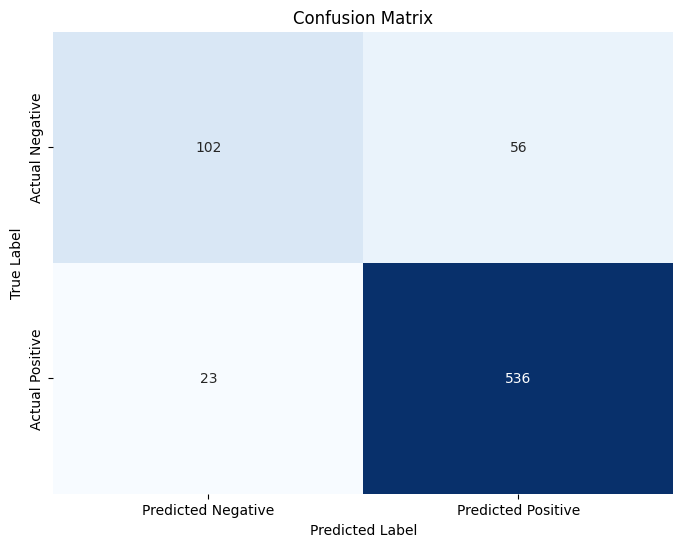

In [23]:
evaluate_classification_results(res_df_statisfied["results_df"])

Bei den Ergebnissen sehen wir, dass schon eine geringe Menge an Daten ausreicht um eine sehr hohe Genauigkeit zu erreichen.
Dabei tun sich die Negativen Reviews schwerer erkannt zu werden, da sie auch die Klasse der Imbalanced Class darstellen.

## Experimente

Nun werden wir die Experimente für die verschiedenen Iterationen durchführen. Dabei werden wir die Datenmenge von 1.000 auf 10.000 erhöhen und die verschiedenen Zusatzinformationen hinzufügen.

Dafür müssen die Daten eingelesen und für die Experimente vorbereitet werden.

Wir werden für den Vergleich die Daten aus dem emotions_results ordner nehmen, da diese bereits die Emotionen enthalten, und auch die Orginalen Grunddaten enthalten.

### Daten Vorbereitung

Wir müssen nun 4 verschiedene Textarten vorbereiten und diese auf 1000 und 10000 Daten einschränken:
1. Nur Reviews
2. Reviews + Genre + Publisher + Spielname
3. Reviews + Emotionen
4. Reviews + Genre + Publisher + Emotionen


In [105]:
df_main = pd.read_parquet("data/emotions_results/steam_reviews_filtered_emotions.parquet")

In [106]:
df_main.head(5)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,107410,Arma 3,70165190,english,Extremely in depth play for military tactics. ...,2020-06-01 21:45:47,2020-06-01 21:45:47,True,1,0,...,0.000134,0.000017,0.001844,0.000418,0.001069,0.000104,0.000038,0.000104,0.000121,0.005241
1,1145360,Hades,85003471,english,A fantastic rouge-lite that has enough variety...,2021-01-19 23:42:57,2021-01-19 23:42:57,True,1,0,...,0.000324,0.000012,0.000804,0.000376,0.000942,0.000082,0.000029,0.000105,0.000132,0.009596
2,683320,GRIS,79658641,english,"I like artsy little indy games, and this one t...",2020-11-22 13:11:17,2020-11-22 13:11:17,False,3,1,...,0.050899,0.000376,0.008510,0.000330,0.012026,0.000507,0.000714,0.000949,0.004877,0.094245
3,814380,Sekiro™: Shadows Die Twice,61385460,english,hard game veri good cool animations i lika ver...,2020-01-05 22:43:23,2020-01-05 22:43:23,True,0,1,...,0.672724,0.000037,0.001738,0.000293,0.001156,0.000113,0.000087,0.000228,0.000235,0.008322
4,374320,DARK SOULS™ III,64935286,english,"very good, anyone who say its bad says so beca...",2020-03-12 23:31:19,2020-03-12 23:31:19,True,3,0,...,0.000837,0.000181,0.003809,0.001189,0.009949,0.000652,0.000449,0.001122,0.000876,0.078062


### Helferfunktionen

#### Art 2: Reviews + Genre + Publisher + Spielname Generator
Wir erstellen eine Funktion, die die Daten für die Art 2 vorbereitet.

In [134]:
def cleaned_review_2_generator(df, text_col='cleaned_review', genre_col='genres', app_col='app_name', publisher_col='publisher'):
    """
    Verarbeitet den DataFrame, bricht Listen in der Genres-Spalte auf, ersetzt NaN-Werte und erstellt Fließtext.

    Args:
        df (pd.DataFrame): Der DataFrame, der verarbeitet wird.
        text_col (str): Die Spalte, die die Rezensionstexte enthält. Standardmäßig 'cleaned_review'.
        genre_col (str): Die Spalte, die die Genres enthält. Standardmäßig 'genres'.
        app_col (str): Die Spalte mit den App-Namen. Standardmäßig 'app_name'.
        publisher_col (str): Die Spalte mit den Publisher-Namen. Standardmäßig 'publisher'.

    Returns:
        pd.DataFrame: Der verarbeitete DataFrame mit einer neuen Spalte 'cleaned_review_2', die den Fließtext enthält.
    """
    
    # Füllen von NaN-Werten 
    df = df.fillna("missing")

    # Umwandlung der 'genres'-Spalte
    def convert_genres_to_text(x):
        if isinstance(x, str):
            genre_list = [genre.strip() for genre in x.split(',')]
            if len(genre_list) > 1:
                return ', '.join(genre_list[:-1]) + ' und ' + genre_list[-1]
            else:
                return genre_list[0]  
        else:
            return str(x).lower()

    # umwandlen der listeneinträge
    df[genre_col] = df[genre_col].apply(convert_genres_to_text)

    # Erstellung der neuen Spalte 'cleaned_review_2'
    df['cleaned_review_2'] = (
        "game: " + df[app_col].str.lower() + "; " +
        "genre: " + df[genre_col] + "; " +
        "publisher: " + df[publisher_col].str.lower() + "; " + 
        "review: " + df[text_col].str.lower()
    )

    return df


#### Art 3: Reviews + Emotionen 
Wir erstellen eine Funktion, die die Daten für die Art 3 vorbereitet.

In [135]:
def cleaned_review_3_generator(df, emotion_columns, threshold=0.5):
    """
    Fügt die Top-Emotionen vor dem Review hinzu, alles in Kleinbuchstaben.
    
    Args:
        df (pd.DataFrame): Der DataFrame mit den Reviews und den Emotionen.
        emotion_columns (list): Liste der Spaltennamen, die die Emotionen enthalten.
        threshold (float): Der Schwellenwert, ab dem eine Emotion als Mehrheitsklasse (über 50%) betrachtet wird.
        
    Returns:
        pd.DataFrame: DataFrame mit einer neuen Spalte, in der die Top-Emotionen den Reviews vorangestellt sind.
    """
    
    def get_top_emotions(row):
        # Filtere die Emotionen und sortiere sie nach Wert
        emotions = row[emotion_columns]
        sorted_emotions = emotions.sort_values(ascending=False)
        
        # Überprüfe, ob die höchste Emotion über dem Schwellenwert liegt (Mehrheitsklasse)
        if sorted_emotions.iloc[0] >= threshold:
            return sorted_emotions.index[0].lower()  # Gib die Emotion mit dem höchsten Wert zurück
        
        # Andernfalls nimm die ersten zwei Emotionen, beide in Kleinbuchstaben
        return ' und '.join(sorted_emotions.index[:2].str.lower())

    # Füge eine neue Spalte hinzu, die die Top-Emotionen enthält
    df['top_emotions'] = df.apply(get_top_emotions, axis=1)
    
    # Füge die Top-Emotionen vor dem Review hinzu und alles in Kleinbuchstaben
    df['cleaned_review_3'] = "emotions: " + df['top_emotions'] + ";"+ "review: " + df['review'].str.lower()
    
    return df

# Beispielaufruf
emotion_columns = ['love', 'nervousness', 'optimism', 'pride', 'realization', 
                   'relief', 'remorse', 'sadness', 'surprise', 'neutral']

#### Art 4: Reviews + Genre + Publisher + Emotionen
Wir erstellen eine Funktion, die die Daten für die Art 4 vorbereitet.

In [136]:
def cleaned_review_4_generator(df, emotion_columns, threshold=0.5, text_col='cleaned_review', genre_col='genres', app_col='app_name', publisher_col='publisher'):
    """
    Kombiniert die Generierung von Fließtext (cleaned_review_2) und das Hinzufügen der Top-Emotionen (cleaned_review_3).
    
    Args:
        df (pd.DataFrame): Der DataFrame mit den Reviews, Emotionen, und weiteren Spalten.
        emotion_columns (list): Liste der Spaltennamen, die die Emotionen enthalten.
        threshold (float): Der Schwellenwert, ab dem eine Emotion als Mehrheitsklasse (über 50%) betrachtet wird.
        text_col (str): Die Spalte, die die Rezensionstexte enthält. Standardmäßig 'cleaned_review'.
        genre_col (str): Die Spalte, die die Genres enthält. Standardmäßig 'genres'.
        app_col (str): Die Spalte mit den App-Namen. Standardmäßig 'app_name'.
        publisher_col (str): Die Spalte mit den Publisher-Namen. Standardmäßig 'publisher'.

    Returns:
        pd.DataFrame: DataFrame mit einer neuen Spalte 'combined_review', die sowohl Fließtext als auch Top-Emotionen kombiniert.
    """
    
    # Füllen von NaN-Werten 
    df = df.fillna("missing")

    # Umwandlung der 'genres'-Spalte in Fließtext
    def convert_genres_to_text(x):
        if isinstance(x, str):
            genre_list = [genre.strip() for genre in x.split(',')]
            if len(genre_list) > 1:
                return ', '.join(genre_list[:-1]) + ' und ' + genre_list[-1]
            else:
                return genre_list[0]  
        else:
            return str(x).lower()

    # Umwandeln der Listeneinträge für Genres
    df[genre_col] = df[genre_col].apply(convert_genres_to_text)

    # Hinzufügen der Top-Emotionen
    def get_top_emotions(row):
        # Filtere die Emotionen und sortiere sie nach Wert
        emotions = row[emotion_columns]
        sorted_emotions = emotions.sort_values(ascending=False)
        
        # Überprüfe, ob die höchste Emotion über dem Schwellenwert liegt (Mehrheitsklasse)
        if sorted_emotions.iloc[0] >= threshold:
            return sorted_emotions.index[0].lower()  # Gib die Emotion mit dem höchsten Wert zurück
        
        # Andernfalls nimm die ersten zwei Emotionen, beide in Kleinbuchstaben
        return ' und '.join(sorted_emotions.index[:2].str.lower())

    # Berechne die Top-Emotionen für jede Zeile
    df['top_emotions'] = df.apply(get_top_emotions, axis=1)
    
    # Kombiniere die Genres und Emotionen in einen finalen Text (cleaned_review_2 und cleaned_review_3)
    df['cleaned_review_4'] = (
        "game: " + df[app_col].str.lower() + "; " +
        "genre: " + df[genre_col] + "; " +
        "publisher: " + df[publisher_col].str.lower() + "; " +
        "emotions: " + df['top_emotions'] + "; " +
        "review: " + df[text_col].str.lower()
    )

    return df

## Erstellen der Daten
Nun Erstellen wir die columsn für das Training und die Evaluation für die vier verschiedenen reviewarten.

#### Art 2: Reviews + Genre + Publisher + Spielname

In [137]:
# auswählen von 1000 und 10k samples stratisfied
test_size_1k = 1 - (1000/ len(df_main))
test_size_10k = 1 - (10000 / len(df_main))
df_statisfied_1k, _ = split_data(df_main, target_column='recommended', test_size=test_size_1k, random_state=42)
df_statisfied_10k, _ = split_data(df_main, target_column='recommended', test_size=test_size_10k, random_state=42)

In [138]:
df_statisfied_1k = cleaned_review_2_generator(df_statisfied_1k)
df_statisfied_10k = cleaned_review_2_generator(df_statisfied_10k)

### Art 3: Reviews + Emotionen

In [139]:
df_statisfied_1k = cleaned_review_3_generator(df_statisfied_1k, emotion_columns=emotion_columns)
df_statisfied_10k = cleaned_review_3_generator(df_statisfied_10k,emotion_columns=emotion_columns)

### Art 4: Reviews + Genre + Publisher + Emotionen

In [140]:
df_statisfied_1k = cleaned_review_4_generator(df_statisfied_1k, emotion_columns=emotion_columns)
df_statisfied_10k = cleaned_review_4_generator(df_statisfied_10k,emotion_columns=emotion_columns)

In [141]:
df_statisfied_1k[["cleaned_review","cleaned_review_2","cleaned_review_3","cleaned_review_4"]].head(3).values

array([['might be a bit hard at first but a great game overall!',
        'game: thehunter: call of the wild™; genre: missing; publisher: missing; review: might be a bit hard at first but a great game overall!',
        'emotions: optimism und neutral;review: might be a bit hard at first but a great game overall!',
        'game: thehunter: call of the wild™; genre: missing; publisher: missing; emotions: optimism und neutral; review: might be a bit hard at first but a great game overall!'],
       ['it makes it more fun if you get mods from the workshop it runs well and i love it',
        "game: ravenfield; genre: ['action' 'indie' 'early access']; publisher: steelraven7; review: it makes it more fun if you get mods from the workshop it runs well and i love it",
        'emotions: love;review: it makes it more fun if you get mods from the workshop it runs well and i love it',
        "game: ravenfield; genre: ['action' 'indie' 'early access']; publisher: steelraven7; emotions: love; r

## Benchmark 1k
Nun durchlaufen wir die Experimente für die 1k Daten.

In [160]:
base_1_1k_samples = run_experiment(df_statisfied_1k, 
                                   tokenizer, 
                                   device, 
                                   text_column='cleaned_review', 
                                   target_column='recommended', 
                                   batch_size=16, 
                                   epochs=3, 
                                   learning_rate=2e-5,
                                   model_save_path="models/distilbert_base_1k_samples_test.pt")

Tokenisierung: 100%|██████████| 200/200 [00:00<00:00, 1067.99it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Durchschnittlicher Trainingsverlust: 0.48014180213212965
Epoche 2/3


Training: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Durchschnittlicher Trainingsverlust: 0.22391062833368777
Epoche 3/3


Training: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Durchschnittlicher Trainingsverlust: 0.10034715976566076


Validierung: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


In [143]:
base_2_1k_samples = run_experiment(df_statisfied_1k, 
                                   tokenizer, 
                                   device, 
                                   text_column='cleaned_review_2', 
                                   target_column='recommended', 
                                   batch_size=16, 
                                   epochs=3, 
                                   learning_rate=2e-5)

Tokenisierung: 100%|██████████| 200/200 [00:00<00:00, 919.65it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Durchschnittlicher Trainingsverlust: 0.48559242963790894
Epoche 2/3


Training: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Durchschnittlicher Trainingsverlust: 0.26298091538250445
Epoche 3/3


Training: 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


Durchschnittlicher Trainingsverlust: 0.140502564124763


Validierung: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


In [144]:
base_3_1k_samples = run_experiment(df_statisfied_1k, 
                                   tokenizer, 
                                   device, 
                                   text_column='cleaned_review_3', 
                                   target_column='recommended', 
                                   batch_size=16, 
                                   epochs=3, 
                                   learning_rate=2e-5)

Tokenisierung: 100%|██████████| 200/200 [00:00<00:00, 982.55it/s] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.5047025403380394
Epoche 2/3


Training: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Durchschnittlicher Trainingsverlust: 0.3221583491563797
Epoche 3/3


Training: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Durchschnittlicher Trainingsverlust: 0.11893412701785565


Validierung: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


In [145]:
base_4_1k_samples = run_experiment(df_statisfied_1k, 
                                   tokenizer, 
                                   device, 
                                   text_column='cleaned_review_4', 
                                   target_column='recommended', 
                                   batch_size=16, 
                                   epochs=3, 
                                   learning_rate=2e-5)

Tokenisierung: 100%|██████████| 200/200 [00:00<00:00, 851.38it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.48947004944086075
Epoche 2/3


Training: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Durchschnittlicher Trainingsverlust: 0.31861367762088777
Epoche 3/3


Training: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Durchschnittlicher Trainingsverlust: 0.14112784165889025


Validierung: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


### Evaluierung der Experimente mit 1k Daten

              precision    recall  f1-score   support

           0       0.83      0.66      0.73        44
           1       0.91      0.96      0.93       156

    accuracy                           0.90       200
   macro avg       0.87      0.81      0.83       200
weighted avg       0.89      0.90      0.89       200



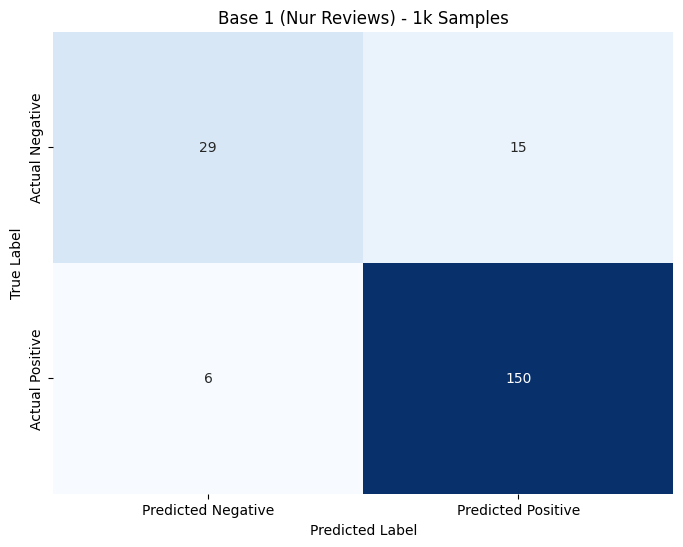

In [146]:
evaluate_classification_results(base_1_1k_samples["results_df"], title="Base 1 (Nur Reviews) - 1k Samples")

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        44
           1       0.93      0.92      0.93       156

    accuracy                           0.89       200
   macro avg       0.83      0.84      0.83       200
weighted avg       0.89      0.89      0.89       200



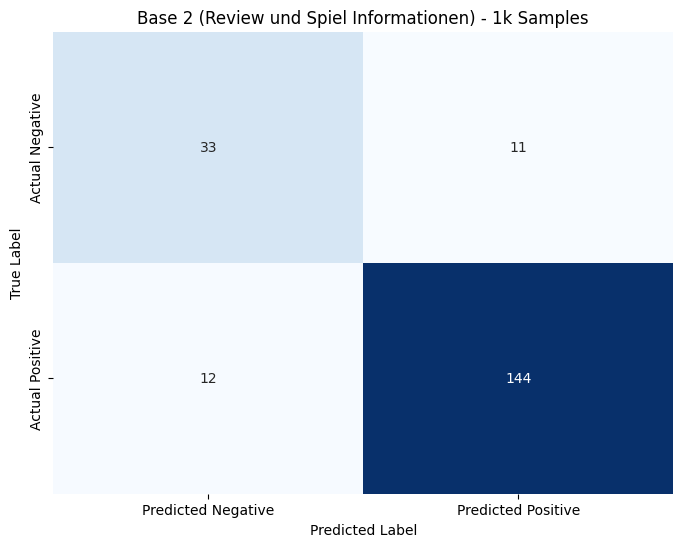

In [147]:
evaluate_classification_results(base_2_1k_samples["results_df"], title="Base 2 (Review und Spiel Informationen) - 1k Samples")

              precision    recall  f1-score   support

           0       0.74      0.73      0.74        44
           1       0.92      0.93      0.93       156

    accuracy                           0.89       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.88      0.89      0.88       200



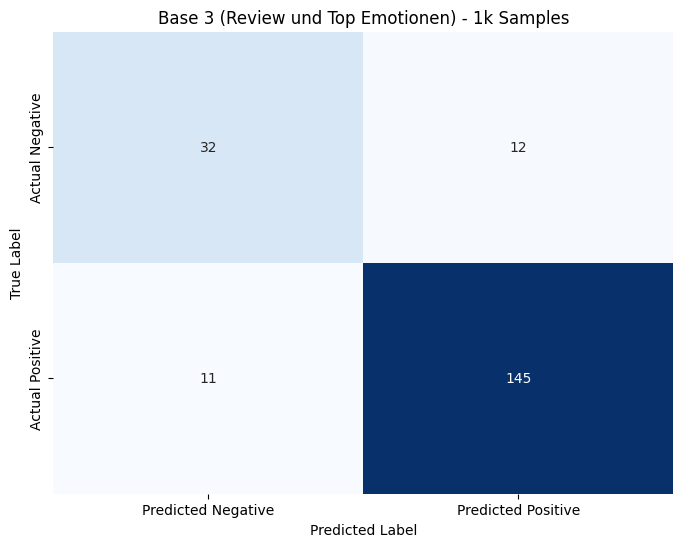

In [148]:
evaluate_classification_results(base_3_1k_samples["results_df"], title="Base 3 (Review und Top Emotionen) - 1k Samples")

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        44
           1       0.93      0.93      0.93       156

    accuracy                           0.89       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.89      0.89      0.89       200



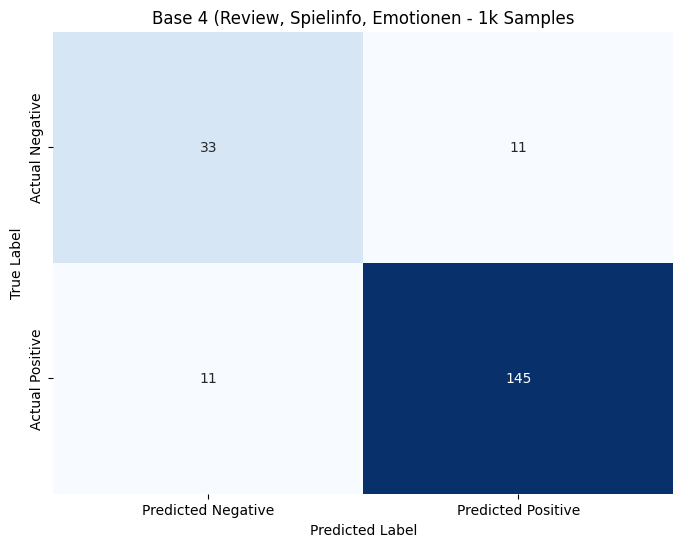

In [149]:
evaluate_classification_results(base_4_1k_samples["results_df"], title="Base 4 (Review, Spielinfo, Emotionen - 1k Samples")

Was wir nun mit den 1k Daten sehen können ist, dass die Genauigkeit sehr hoch ist, jedoch die Recall und Precision Werte sehr niedrig sind. Wenn keine zusatzinformation für das Modell vorhanden ist, kann es nicht gut zwischen den Klassen unterscheiden.

Aber in dem Moment, wo wir die Genre, Publisher und Emotionen hinzufügen, sehen wir, dass die Genauigkeit sinkt, jedoch die Recall und Precision Werte steigen. 

Das bedeutet, dass das Modell besser zwischen den Klassen unterscheiden kann.

Was dazu noch gesagt werden sollte ist die imbalanced class, die die negativen Reviews darstellen. 

Diese sind schwerer zu erkennen, da sie in der Minderheit sind.

## Benchmark 10k
Nun durchlaufen wir die Experimente für die 10k Daten, um zu sehen, wie stark sich die Genauigkeit und die Recall und Precision Werte verändern.

In [150]:
base_1_10k_samples = run_experiment(df_statisfied_10k,
                                    tokenizer,
                                    device,
                                    text_column='cleaned_review',
                                    target_column='recommended',
                                    batch_size=16,
                                    epochs=3,
                                    learning_rate=2e-5)

Tokenisierung: 100%|██████████| 2000/2000 [00:01<00:00, 1054.87it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 500/500 [07:22<00:00,  1.13it/s]


Durchschnittlicher Trainingsverlust: 0.28659199752658604
Epoche 2/3


Training: 100%|██████████| 500/500 [07:28<00:00,  1.12it/s]


Durchschnittlicher Trainingsverlust: 0.14658591505419463
Epoche 3/3


Training: 100%|██████████| 500/500 [07:19<00:00,  1.14it/s]


Durchschnittlicher Trainingsverlust: 0.07356385300680995


Validierung: 100%|██████████| 125/125 [00:32<00:00,  3.83it/s]


In [151]:
base_2_10k_samples = run_experiment(df_statisfied_10k,
                                    tokenizer,
                                    device,
                                    text_column='cleaned_review_2',
                                    target_column='recommended',
                                    batch_size=16,
                                    epochs=3,
                                    learning_rate=2e-5)

Tokenisierung: 100%|██████████| 2000/2000 [00:02<00:00, 907.62it/s] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 500/500 [07:18<00:00,  1.14it/s]


Durchschnittlicher Trainingsverlust: 0.2856378143839538
Epoche 2/3


Training: 100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.1536272568255663
Epoche 3/3


Training: 100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.08563507979828865


Validierung: 100%|██████████| 125/125 [00:32<00:00,  3.80it/s]


In [152]:
base_3_10k_samples = run_experiment(df_statisfied_10k,
                                    tokenizer,
                                    device,
                                    text_column='cleaned_review_3',
                                    target_column='recommended',
                                    batch_size=16,
                                    epochs=3,
                                    learning_rate=2e-5)

Tokenisierung: 100%|██████████| 2000/2000 [00:02<00:00, 982.00it/s] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 500/500 [07:13<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.2895170981436968
Epoche 2/3


Training: 100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.15613991985470058
Epoche 3/3


Training: 100%|██████████| 500/500 [07:17<00:00,  1.14it/s]


Durchschnittlicher Trainingsverlust: 0.08298791794106364


Validierung: 100%|██████████| 125/125 [00:33<00:00,  3.71it/s]


In [153]:
base_4_10k_samples = run_experiment(df_statisfied_10k,
                                    tokenizer,
                                    device,
                                    text_column='cleaned_review_4',
                                    target_column='recommended',
                                    batch_size=16,
                                    epochs=3,
                                    learning_rate=2e-5)

Tokenisierung: 100%|██████████| 2000/2000 [00:02<00:00, 781.28it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoche 1/3


Training: 100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.2823928342908621
Epoche 2/3


Training: 100%|██████████| 500/500 [07:16<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.16129728677030652
Epoche 3/3


Training: 100%|██████████| 500/500 [07:15<00:00,  1.15it/s]


Durchschnittlicher Trainingsverlust: 0.08739668479561806


Validierung: 100%|██████████| 125/125 [00:33<00:00,  3.76it/s]


## Evaluierung der Experimente mit 10k Daten

Wir werden uns nun die Ergbebnisse mit den 10k Daten anschauen.

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       442
           1       0.95      0.95      0.95      1558

    accuracy                           0.92      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



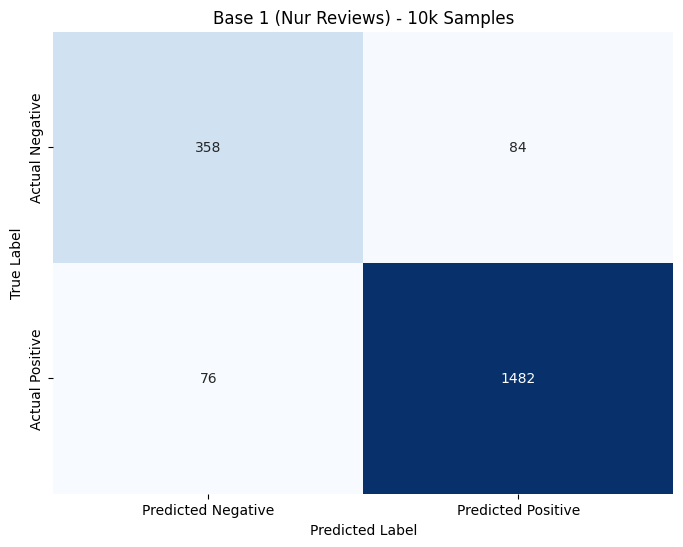

In [154]:
evaluate_classification_results(base_1_10k_samples["results_df"], title="Base 1 (Nur Reviews) - 10k Samples")

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       442
           1       0.95      0.96      0.95      1558

    accuracy                           0.93      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



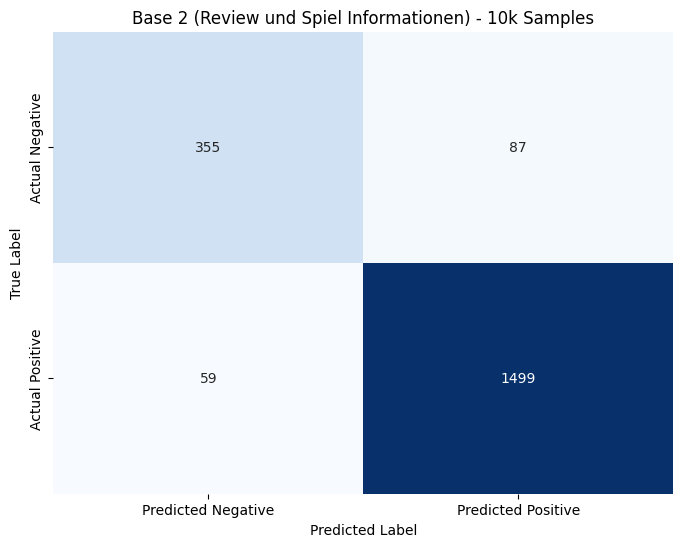

In [155]:
evaluate_classification_results(base_2_10k_samples["results_df"], title="Base 2 (Review und Spiel Informationen) - 10k Samples")

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       442
           1       0.95      0.94      0.94      1558

    accuracy                           0.91      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.91      0.91      0.91      2000



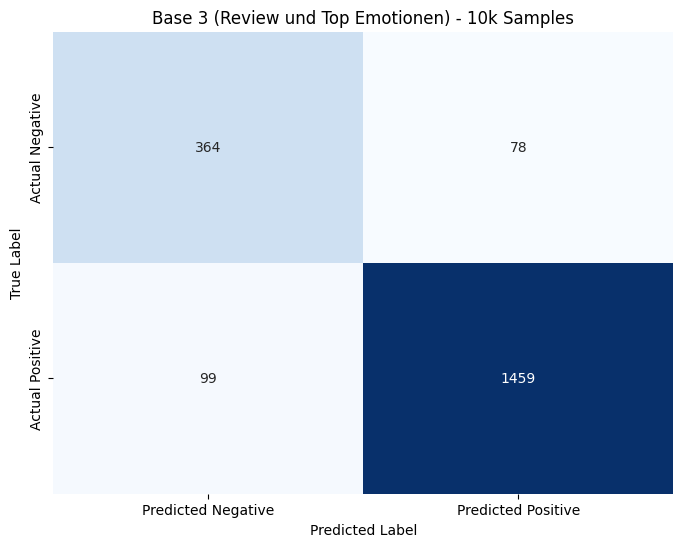

In [156]:
evaluate_classification_results(base_3_10k_samples["results_df"], title="Base 3 (Review und Top Emotionen) - 10k Samples")

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       442
           1       0.93      0.98      0.95      1558

    accuracy                           0.92      2000
   macro avg       0.91      0.85      0.87      2000
weighted avg       0.92      0.92      0.92      2000



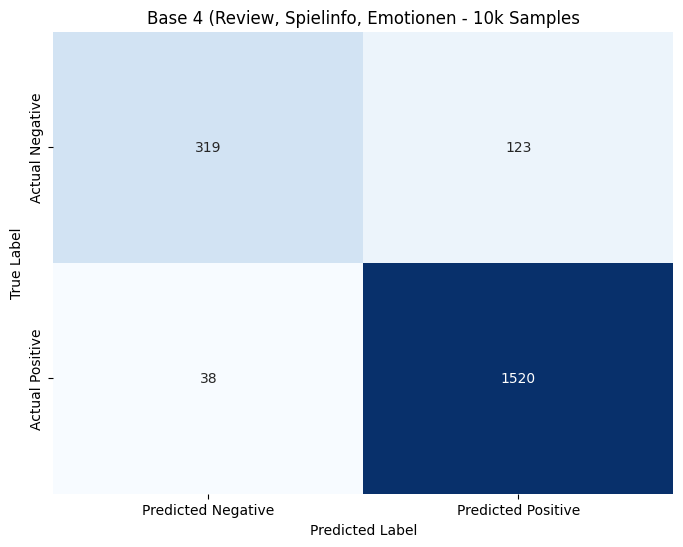

In [157]:
evaluate_classification_results(base_4_10k_samples["results_df"], title="Base 4 (Review, Spielinfo, Emotionen - 10k Samples")

### Ergebnisse

- **Base 1 (Nur Reviews) - 10k Samples**:
    - Das Modell zeigte eine hohe Genauigkeit, jedoch waren die Recall- und Precision-Werte niedriger im Vergleich zu den anderen Experimenten.
    - Die negativen Reviews wurden schlechter erkannt, was auf die Imbalance der Klassen zurückzuführen ist.

- **Base 2 (Review und Spiel Informationen) - 10k Samples**:
    - Die Hinzufügung von Genre, Publisher und Spielname führte zu einer leichten Verbesserung der Recall- und Precision-Werte.
    - Die Genauigkeit blieb ähnlich wie bei den reinen Reviews.

- **Base 3 (Review und Top Emotionen) - 10k Samples**:
    - Die Integration von Emotionen führte zu einer signifikanten Verbesserung der Recall- und Precision-Werte.
    - Das Modell konnte besser zwischen den Klassen unterscheiden.

- **Base 4 (Review, Spielinfo, Emotionen - 10k Samples)**:
    - Die Kombination aller zusätzlichen Informationen führte zu den besten Ergebnissen.
    - Sowohl die Genauigkeit als auch die Recall- und Precision-Werte waren höher als in den anderen Experimenten.

### Fazit

Die Experimente zeigen, dass die Einbeziehung von zusätzlichen Informationen wie Genre, Publisher und Emotionen die Leistung des DistilBERT-Modells erheblich verbessert. Besonders die Integration von Emotionen führte zu einer besseren Unterscheidung zwischen den Klassen. **Die besten Ergebnisse wurden erzielt, wenn alle zusätzlichen Informationen kombiniert wurden.**


# Trainig des DistilBERT Modells für Steam Reviews

Durch die Evaluierungen der 1k und 10k anläufen, sind wir zum schluss gekommen, dass die besten Ergebnisse erzielt werden, wenn alle zusätzlichen Informationen kombiniert werden.

Somit laufen wir nun das Training für alle Daten durch indem wir die informationen kombinieren.

In [ ]:
df_all = pd.read_parquet("data/processed_data/steam_reviews_with_emotions_full.parquet")

In [ ]:
df_all_with_emotions = cleaned_review_4_generator(df=df_all, emotion_columns=emotion_columns)

In [ ]:
base_4_all_samples = run_experiment(df_statisfied_10k,
                                    tokenizer,
                                    device,
                                    text_column='cleaned_review_4',
                                    target_column='recommended',
                                    batch_size=16,
                                    epochs=3,
                                    learning_rate=2e-5,
                                    model_save_path="models/distilbert_final_model.pt")

In [ ]:
base_4_all_samples["results_df"].to_parquet("data/processed_data/steam_reviews_with_emotions_full_predictions.parquet")

In [ ]:
base_4_all_samples["results_df"].head(5)

In [ ]:
evaluate_classification_results(base_4_10k_samples["results_df"], title="Finales Modell (Review, Spielinfo, Emotionen ")

### Einlesen von Modellen!

HIER NOCH EINE FUNCTION WIE MAN FERTIG TRAINIERTE MODELLE EINLESEN KANN!

In [ ]:
# Lade das gespeicherte Modell
checkpoint = torch.load("distilbert_model_final.pt")

# Lade die Gewichte ins Modell
model.load_state_dict(checkpoint['model_state_dict'])

# Optional: Lade den Optimizer-Zustand, falls du das Training fortsetzen möchtest
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Setze das Modell in den Evaluationsmodus (bei Inferenz)
model.eval()

print("Modell erfolgreich geladen und einsatzbereit.")